# Modules


In [ ]:
verbose = 1 # @param {type:"slider", min:0, max:3, step:1}
verbose = min(max(verbose, 0), 3) # clamp to [0, 3]

colab = False
try:
    from google.colab import drive

    colab = True
    drive.mount('/content/drive', force_remount=True)
    drive_dir = "bronte" # @param {type:"string"}
    path = "/".join(["drive", "MyDrive", drive_dir])
    %cd $path
except:
    pass

# system
import logging
import os
import subprocess
import sys
import warnings

# This will install the packages below. If you use an environment manager, comment this
# out and make sure the packages in requirements.txt are installed in your environment.
if verbose:
    print("Fetching any missing dependencies...")
reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed = [r.decode().split('==')[0] for r in reqs.split()]
failure = []
with open("requirements.txt", 'r') as dependencies:
    for pkg in dependencies.readlines(): # to ignore errors
        # if pkg is a comment or empty line
        if pkg.startswith('#') or len(pkg.strip()) == 0:
            continue
        pkg = pkg.strip()
        args = f"pip install {pkg} {' '.join(['-q' for _ in range(3 - verbose)])} --break-system-packages"
        if pkg not in installed and subprocess.call(args.split()) != 0:
            failure.append(pkg)

if len(failure) > 0 and failure[0]:
    print("Failed to install the following packages: " + str(failure))
    print("Try installing them manually.")
    raise SystemExit(1)
elif verbose:
    print("All dependencies are installed.")

warnings.filterwarnings("ignore")

# Preprocessing
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from ydata_profiling import ProfileReport

# ML
import torch
from torch import nn
from src.main import Bronte

# Parallelization
import joblib
import dask.config as dc
from dask.distributed import Client

levels = [
    'critical',
    'error',
    'warn',
    'info',
]

dc.set({'logging.distributed': levels[verbose]})

Fetching any missing dependencies...
All dependencies are installed.


# ETL Pipeline


## Extraction


In [ ]:
def load_data_sources(filepaths):
    data = {}
    for name, path_or_paths in filepaths.items():
        if isinstance(path_or_paths, str):  # If it's a single string, read that CSV
            data[name] = [pd.read_csv(path_or_paths)]
        else:  # If it's a list of strings, read each CSV into a list of dataframes
            data[name] = [pd.read_csv(path) for path in path_or_paths]
    return data


def preprocess_aux_data(df):
    if "Player" in df.columns:
        df["playerNameI"] = df["Player"].apply(
            lambda x: x[0] + ". " + " ".join(x.split(" ")[1:])
        )
        df = df.drop("Player", axis=1)
    if "Tm" in df.columns:
        df["teamTricode"] = df["Tm"]
        df = df.drop("Tm", axis=1)
    return df


def merge_main_data(dfs, key):
    main_df = dfs[0]
    for secondary_df in dfs[1:]:
        main_df = pd.merge(main_df, secondary_df, on=key, how="left")
    return main_df


def merge_aux_data(main_df, dfs, key):
    merged_dfs = pd.concat(dfs, ignore_index=True)
    merged_dfs = merged_dfs.drop_duplicates(subset=key)

    merged_main_df = main_df.merge(merged_dfs, on=key, how="left", suffixes=("", "_y"))
    return merged_main_df.drop(
        [col for col in merged_main_df.columns if col.endswith("_y")], axis=1
    )


def plot_court(data, title, path="./", color="black"):
    fig = plt.figure(figsize=(4, 3.76))
    ax = fig.add_axes([0, 0, 1, 1])

    # 3PT lines + Arc
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    x = np.linspace(-220, 220, 400)
    ax.plot(x, 140 + (np.sqrt(1 - (x**2 / 220**2)) * 155), linewidth=2, color=color)

    # Lane + Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)

    # Free Throw Circle + Rim + Backboard
    theta = np.linspace(0, 2 * np.pi, 100)
    ax.plot(60 * np.cos(theta), 60 * np.cos(theta), linewidth=2, color=color)
    ax.plot(15 * np.cos(theta), 15 * np.sin(theta) + 60, linewidth=2, color=color)
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)

    # Remove ticks and set limits
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)

    # Plays
    hb = ax.hexbin(
        *(data[0], data[1] + 60),
        gridsize=(30, 30),
        extent=(-300, 300, 0, 940),
        bins="log" if len(data[0]) > 100 else None,
        cmap="Oranges",
    )
    # legend
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label("Counts", fontsize=16)

    # if path/court doesn't exist, create it
    loc = "".join([path, "court/"])
    if not os.path.exists(loc):
        os.makedirs(loc)

    # Title
    plt.title(title, fontsize=18, fontweight="bold", y=1.05)
    plt.savefig("".join([loc, title, ".png"]), dpi=300)
    plt.show()


# Load data
path = "./data/"
filepaths = {"games": ["plays-2022-23.csv"], "players": ["players-2022-23.csv"]}
# prepend path to filepaths, which is a list of lists
data_sources = load_data_sources(
    {
        name: [os.path.join(path, path_or_paths) for path_or_paths in paths]
        for name, paths in filepaths.items()
    }
)

# Ensure sources are loaded
assert len(data_sources) > 0 and all(
    [len(df) > 0 for df_list in data_sources.values() for df in df_list]
)

# Combine sources
df = pd.DataFrame()
main_key = "game_id"
aux_key = ["playerNameI", "teamTricode"]
for name, dfs in data_sources.items():
    dfs = [preprocess_aux_data(df) for df in dfs]
    if name == "games":
        df = merge_main_data(dfs, main_key)
    else:
        df = merge_aux_data(df, dfs, aux_key)

# EDA
plot_court((df["xLegacy"], df["yLegacy"]), "All Play Locations", path)

# profile = ProfileReport(df, explorative=True)
# profile.to_file("".join([path, "profile.html"]))

# if colab:
#    profile.to_notebook_iframe()
# else:
#    profile.to_widgets()

## Transformation


### Cleaning


In [ ]:
# Keep columns that contain at least one letter
df = df[[col for col in df.columns if any(char.isalpha() for char in col)]]

# remove unnamed columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# remove commas
for col in df.columns:
    if df[col].dtype == "object":
        try:
            df[col] = pd.to_numeric(df[col].str.replace(",", ""))
        except ValueError:
            pass

# Drop rows where player is missing
df = df.dropna(subset=["playerNameI"])

# Update numerical_features and categorical_features lists
numerical_features = df.select_dtypes(include=["number"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

# Define transformers
numerical_transformers = Pipeline(
    steps=[
        (
            "imputer",
            IterativeImputer(
                estimator=BayesianRidge(),
                # max_iter=25,
                random_state=42,
                sample_posterior=True,
                skip_complete=True,
                n_nearest_features=max(len(numerical_features) // 5, 5),
            ),
        )
    ]
)

categorical_transformers = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformers, numerical_features),
        ("cat", categorical_transformers, categorical_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Apply the transformations
client = Client(n_workers=os.cpu_count())
with joblib.parallel_backend("dask"):
    df = pd.DataFrame(
        pipeline.fit_transform(df), columns=numerical_features + categorical_features
    )
client.close()

# Drop rows with missing or duplicate values
df = df.dropna()
df = df.drop_duplicates()

df.head()

### Feature Engineering


In [ ]:
if "clock" in df.columns:
    # Let's convert the clock str to number of seconds
    minute = df["clock"].apply(lambda x: int(x.split(":")[0]))
    second = df["clock"].apply(lambda x: float(x.split(":")[1]))
    time = minute * 60 + second
    df["time"] = max(time) - time  # this reverses the clock so that it counts up

# Create new columns for various checks
df["is_rebound"] = df["actionType"] == "Rebound"
df["is_field_goal_attempt"] = df["isFieldGoal"] == 1

# Calculate shifted columns in one go to reduce redundant operations
df_next = df[["teamTricode", "is_rebound", "is_field_goal_attempt", "time"]].shift(-1)
df_next_next = df[["teamTricode", "is_field_goal_attempt", "time"]].shift(-2)

# Create conditions for better readability
df["led_to_off_rebound"] = (
    df_next["is_rebound"] & (df_next["teamTricode"] == df["teamTricode"])
) & (df["is_field_goal_attempt"] & (df["scoreVal"] == 0))

df["led_to_transition_opp"] = (
    df_next_next["is_field_goal_attempt"]
    & (df_next_next["teamTricode"] != df["teamTricode"])
    & ((df_next_next["time"] - df["time"]) <= 5)
) & (df["is_field_goal_attempt"] & (df["scoreVal"] == 0))

del df_next
del df_next_next

# Handle the last play of the game
df.loc[
    df["teamTricode"].shift(-1).isnull(),
    ["led_to_off_rebound", "led_to_transition_opp"],
] = False

# Define aggregation functions
agg_funcs = {
    "num_shots": ("is_field_goal_attempt", "sum"),
    "num_made": ("scoreVal", "sum"),
    "num_off_rebounds": ("led_to_off_rebound", "sum"),
    "num_transition_opps": ("led_to_transition_opp", "sum"),
}

# Apply aggregation functions
for col_agg, (col, func) in agg_funcs.items():
    df[col_agg] = df.groupby(["xLegacy", "yLegacy"])[col].transform(func)

# Calculate total possessions for each player
df["Possessions"] = df["FGA"] + 0.44 * df["FTA"] - df["ORB"] + df["TOV"]

# Create a column to track turnovers that led to live ball situations
df["is_turnover"] = (df["actionType"] == "Turnover") & df["led_to_transition_opp"]

# Group by playerNameI and calculate turnovers
turnovers = (
    df.groupby("playerNameI")
    .agg(is_turnover_live_ball=("is_turnover", "sum"), TOV_total=("TOV", "sum"))
    .reset_index()
)

# Merge the turnover data with the main dataframe
df = df.merge(turnovers, on="playerNameI", how="left")

# Calculate the rates
off_rebound_rate = df["num_off_rebounds"] / df["num_shots"]
transition_opp_rate = df["num_transition_opps"] / df["num_shots"]
live_to_rate = df["is_turnover_live_ball"] / df["Possessions"]
dead_to_rate = (df["TOV_total"] - df["is_turnover_live_ball"]) / df["Possessions"]
shot_rate = df["num_made"] / df["num_shots"]

PPP = df["scoreVal"] / df["Possessions"]
rates = off_rebound_rate + dead_to_rate - transition_opp_rate - live_to_rate
df["PPP*rates"] = PPP * rates

cols_to_remove = [
    "is_rebound",
    "is_turnover",
    "is_field_goal_attempt",
    "led_to_off_rebound",
    "led_to_transition_opp",
    "clock",
    "num_shots",
    "num_made",
    "num_off_rebounds",
    "num_transition_opps",
    "Possessions",
    "description",
    "is_turnover_live_ball",
    "TOV_total",
    "Player-additional",
]

# Drop the listed columns
df.drop(columns=cols_to_remove, inplace=True, errors="ignore")

# Coerce scoreVal to int
df["scoreVal"] = df["scoreVal"].round().astype(int)

# Plot the top plays by PPP*rates
for percent in [1e-1, 1, 1e1]:
    for col in ["PPP*rates"]:
        filtered = df[df["xLegacy"] != 0]
        filtered = filtered[filtered["yLegacy"] != 0]
        sorted = filtered.sort_values(by=col, ascending=False).reset_index(drop=True)
        sorted["rank"] = (sorted.index + 1) / len(sorted) * 100
        sorted = sorted[sorted["rank"] <= percent]
        plot_court(
            (sorted["xLegacy"], sorted["yLegacy"]),
            f"Top {percent}% of Play Locations by {col}",
            path,
        )

## Loading


In [ ]:
db = sqlite3.connect("".join([path, "data.db"]))
prefix = "bronte_"

# clear database
cursor = db.cursor()
for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    cursor.execute(f"DROP TABLE {row[0]}")

unique_keys = df[main_key].unique()

# Split game IDs into chunks of size 8
chunk_size = 8  # roughly 4000 rows per 8 games (500 rows per game)
chunks = [
    unique_keys[i : i + chunk_size] for i in range(0, len(unique_keys), chunk_size)
]

for index, chunk in enumerate(chunks):
    subset = df[df[main_key].isin(chunk)]
    table_name = f"{prefix}{index}"
    subset.to_sql(table_name, db, if_exists="replace", index=False)

db.close()

# Deep Learning


## Options


### General


In [ ]:
task_options = {}
model_options = {}

# runs
task_options["restart"] = True  # clear checkpoints before training, restarts training
task_options["resume"] = True  # resume from best checkpoint, enables transfer learning

# data
task_options["targets"] = ["PPP*rates"]
task_options["db_path"] = "data/data.db"
task_options["table_prefix"] = "data_chunk_"
task_options["timeseries"] = False
task_options["samples"] = 2  # max number of tables to use for training
task_options[
    "sample_size"
] = 0  # fraction of each table to use or number of rows, 0 for all
task_options["max_corr"] = 0.95  # maximum correlation between features
task_options["task"] = None  # None for auto; RegTask or ClassTask
task_options["max_clusters"] = 10  # determine limit for unique y values if task is None

# performance
task_options["verbose"] = verbose
task_options["use_cuda"] = torch.cuda.is_available()
task_options["device"] = "cuda" if task_options["use_cuda"] else "cpu"
task_options["autocast"] = torch.float16 if task_options["use_cuda"] else torch.bfloat16
task_options["n_workers"] = os.cpu_count() or 1
task_options["batch_size"] = 192
task_options["drop_last"] = True  # if smaller
task_options["accumulate"] = 1  # set <=1 to disable gradient accumulation
task_options["use_checkpoint"] = task_options[
    "use_cuda"
]  # checkpoint.checkpoint, not .pt files
task_options["tune_trials"] = (
    0 if task_options["use_cuda"] else 5
)  # set <=0 to disable tuning
task_options["colab"] = colab

# hyperparameters
model_options["epochs"] = 2
model_options["lr"] = 1e-3
model_options["patience"] = 0
model_options["factor"] = 0.6
model_options["betas"] = (0.9, 0.75)
model_options["eps"] = 1e-9
model_options["decay"] = 3e-3

# gradient
model_options["norm_clip"] = 1.0  # clip gradient norms at this value
model_options["init_scale"] = 2**16
model_options["growth_factor"] = 2
model_options["backoff_factor"] = 0.5
model_options["growth_interval"] = 2000
model_options["grad_scaling"] = task_options["use_cuda"]

# transfer learning
model_options["freeze"] = []  # list of layers to freeze

### Specific


In [ ]:
def dict_copy(orig):
    dup = {}
    for key, value in orig.items():
        try:
            dup[key] = deepcopy(value)
        except:
            dup[key] = value
    return dup


db = sqlite3.connect(task_options["db_path"])
n_cols = pd.read_sql_query(
    f'SELECT COUNT(*) FROM {task_options["table_prefix"]}1', db
).values[0][0]
db.close()

# arch
ffn_opts = dict_copy(model_options)
ffn_opts["arch"] = "ffn"
ffn_opts["fc_layers"] = [n_cols * 2 // 3] * 3
ffn_opts["fc_dropout"] = np.repeat(0.5, len(ffn_opts["fc_layers"]))

rnn_opts = dict_copy(model_options)
rnn_opts["arch"] = "rnn"
rnn_opts["fc_layers"] = [n_cols * 2 // 3] * 3
rnn_opts["fc_dropout"] = np.repeat(0.5, len(rnn_opts["fc_layers"]))
rnn_opts["rnn_layers"] = 2
rnn_opts["rnn_dropout"] = 0.8
rnn_opts["rnn_type"] = "GRU"  # 'GRU' (or 'LSTM', a bit buggy)
rnn_opts["rnn_seq_len"] = 128
rnn_opts["rnn_bidi"] = True  # task_options["timeseries"]
rnn_opts["attention"] = "concat"  # 'dot', 'general', or 'concat', or None

# task
reg_opts = dict_copy(task_options)
reg_opts["task"] = "reg"
reg_opts["criterion"] = nn.HuberLoss(reduction="none")

class_opts = dict_copy(task_options)
class_opts["task"] = "class"
class_opts["criterion"] = nn.CrossEntropyLoss(
    reduction="none"
)  # or something like MultiLabelMarginLoss

multi_reg_opts = dict_copy(reg_opts)
multi_reg_opts["targets"].append("scoreVal")

multi_class_opts = dict_copy(class_opts)
multi_class_opts["targets"].append("scoreVal")

## Training


Dask dashboard is available at http://127.0.0.1:8787/status

Splitting data and transforming features...
Tuning Training a new reg ffn model to predict ['PPP*rates']...


[I 2023-12-31 08:57:13,653] A new study created in RDB with name: reg ffn [['PPP*rates']] 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 1.5653e-01.
[I 2023-12-31 08:59:39,112] Trial 0 finished with value: 0.19740921507279077 and parameters: {'accumulate': 2, 'batch_size': 162, 'beta1': 0.5542440437916014, 'beta2': 0.723026016196226, 'decay': 0.013886782762859517, 'epochs': 5, 'eps': 8.812121945473351e-08, 'factor': 0.3905578048187639, 'ff_dropout_0': 0.20293420668742224, 'ff_dropout_1': 0.19704802220587136, 'ff_dropout_2': 0.3366617870511206, 'ff_dropout_3': 0.9300988133094366, 'ff_dropout_4': 0.8046281430616268, 'ff_dropout_5': 0.7146419836877295, 'layer_0_size': 5374, 'layer_1_size': 4406, 'layer_2_size': 6184, 'layer_3_size': 2210, 'layer_4_size': 4659, 'layer_5_size': 4256, 'lr': 0.40077941147793333, 'n_layers': 6, 'patience': 0}. Best is trial 0 with value: 0.19740921507279077.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00002: reducing learning rate of group 0 to 4.8459e-02.
Epoch 00015: reducing learning rate of group 0 to 2.4591e-02.
[I 2023-12-31 09:07:07,928] Trial 1 finished with value: 0.16875773668289185 and parameters: {'accumulate': 8, 'batch_size': 134, 'beta1': 0.5957174679182639, 'beta2': 0.6487555793765309, 'decay': 0.006307718365085164, 'epochs': 15, 'eps': 4.207254870874689e-09, 'factor': 0.5074534157190245, 'ff_dropout_0': 0.27327582256863847, 'ff_dropout_1': 0.4733910940079977, 'ff_dropout_2': 0.4666451493792636, 'ff_dropout_3': 0.21970457848634284, 'ff_dropout_4': 0.47753207257967256, 'ff_dropout_5': 0.3009161783147051, 'layer_0_size': 4173, 'layer_1_size': 2733, 'layer_2_size': 1941, 'layer_3_size': 5372, 'layer_4_size': 6387, 'layer_5_size': 5521, 'lr': 0.09549541522719247, 'n_layers': 6, 'patience': 0}. Best is trial 1 with value: 0.16875773668289185.


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00002: reducing learning rate of group 0 to 7.4678e-04.
Epoch 00004: reducing learning rate of group 0 to 6.9872e-04.
Epoch 00006: reducing learning rate of group 0 to 6.5375e-04.
Epoch 00007: reducing learning rate of group 0 to 6.1167e-04.
Epoch 00008: reducing learning rate of group 0 to 5.7231e-04.
Epoch 00009: reducing learning rate of group 0 to 5.3547e-04.
Epoch 00010: reducing learning rate of group 0 to 5.0101e-04.
Epoch 00011: reducing learning rate of group 0 to 4.6877e-04.
Epoch 00012: reducing learning rate of group 0 to 4.3860e-04.
Epoch 00013: reducing learning rate of group 0 to 4.1037e-04.
[I 2023-12-31 09:10:40,566] Trial 2 finished with value: 0.05662773922085762 and parameters: {'accumulate': 5, 'batch_size': 234, 'beta1': 0.7016565765522917, 'beta2': 0.6729926857280559, 'decay': 0.010342138407488478, 'epochs': 14, 'eps': 5.3225926052619746e-09, 'factor': 0.9356409789319172, 'ff_dropout_0': 0.888065442691814, 'ff_dropout_1': 0.1338058265552048, 'ff_dropout_2':

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 00002: reducing learning rate of group 0 to 2.9729e-01.
Epoch 00003: reducing learning rate of group 0 to 2.6802e-01.
Epoch 00004: reducing learning rate of group 0 to 2.4163e-01.
Epoch 00005: reducing learning rate of group 0 to 2.1783e-01.
Epoch 00006: reducing learning rate of group 0 to 1.9638e-01.
Epoch 00007: reducing learning rate of group 0 to 1.7704e-01.
Epoch 00008: reducing learning rate of group 0 to 1.5961e-01.
Epoch 00009: reducing learning rate of group 0 to 1.4389e-01.
[I 2023-12-31 09:27:30,637] Trial 3 pruned. 


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 00002: reducing learning rate of group 0 to 6.8666e-06.
Epoch 00003: reducing learning rate of group 0 to 1.8722e-06.
Epoch 00004: reducing learning rate of group 0 to 5.1044e-07.
Epoch 00005: reducing learning rate of group 0 to 1.3917e-07.
Epoch 00006: reducing learning rate of group 0 to 3.7944e-08.
[I 2023-12-31 09:29:04,934] Trial 4 finished with value: 0.09538262337446213 and parameters: {'accumulate': 8, 'batch_size': 227, 'beta1': 0.9904384263368271, 'beta2': 0.8212981293392149, 'decay': 0.004844836673583623, 'epochs': 9, 'eps': 9.646997607251967e-08, 'factor': 0.2726466712505541, 'ff_dropout_0': 0.4841302434931848, 'ff_dropout_1': 0.8572713658050636, 'ff_dropout_2': 0.4479382408001529, 'ff_dropout_3': 0.19865627807410424, 'ff_dropout_4': 0.5735642531387322, 'layer_0_size': 2123, 'layer_1_size': 3207, 'layer_2_size': 5571, 'layer_3_size': 2609, 'layer_4_size': 4498, 'lr': 2.518503783687566e-05, 'n_layers': 5, 'patience': 0}. Best is trial 2 with value: 0.05662773922085762

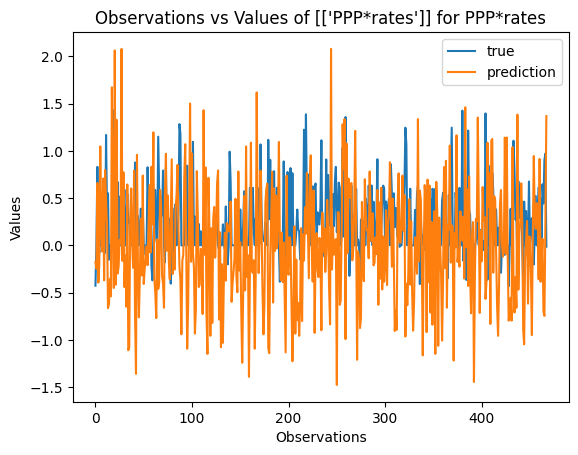

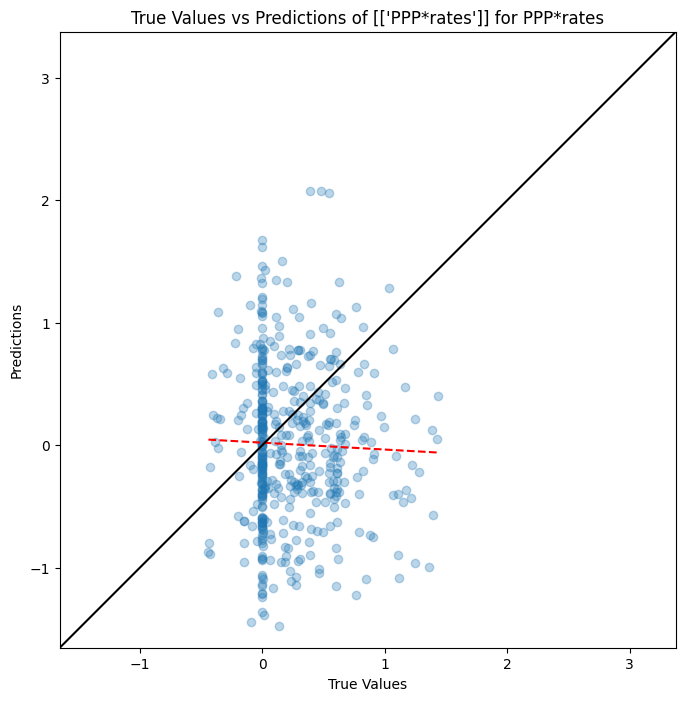

Correlation Coefficient: -0.03130184799152621
Calculating SHAP values...


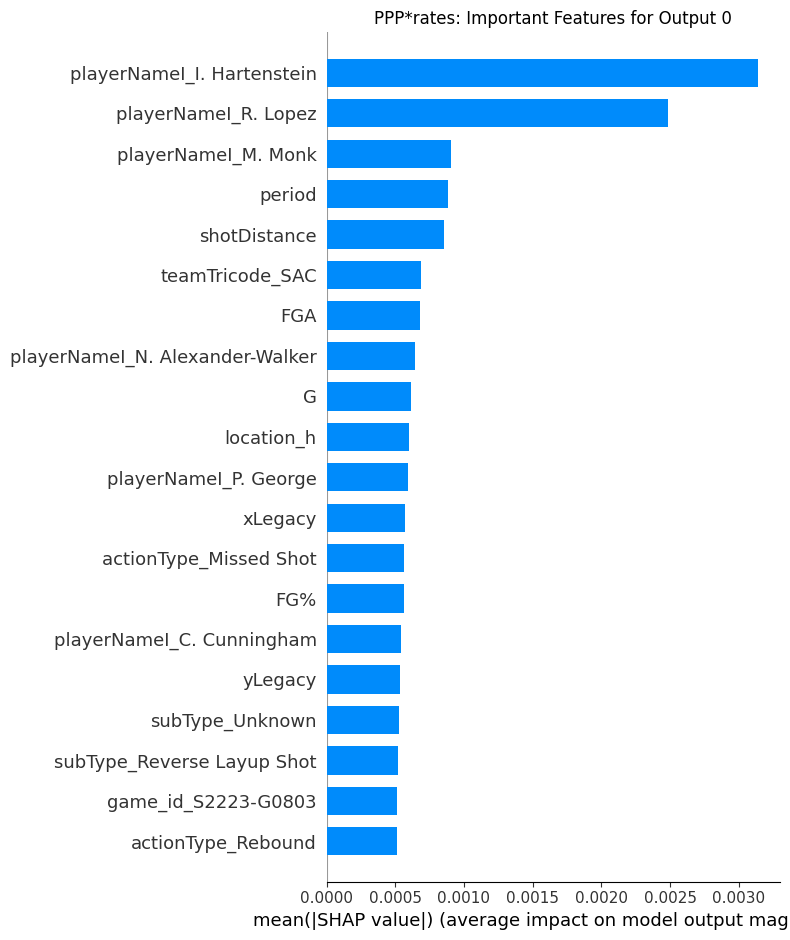


Splitting data and transforming features...
Resuming Training ['PPP*rates'] reg ffn model to predict ['PPP*rates']...


  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 15
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.30013900250196457
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.343243271112442

Epoch 16
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.31365086138248444
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.5966191291809082
Epoch 00016: reducing learning rate of group 0 to 7.4678e-04.

Epoch 17
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.3422713316977024
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.11648666486144066

Epoch 18
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.3438445217907429
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.45694875717163086
Epoch 00018: reducing learning rate of group 0 to 6.9872e-04.

Epoch 19
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.33480897545814514
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.05939437076449394

Epoch 20
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.3409115895628929
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.08368906378746033
Epoch 00020: reducing learning rate of group 0 to 6.5375e-04.

Epoch 21
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.3302110768854618
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.05142690986394882

Epoch 22
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.3240631893277168
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.16358306258916855
Epoch 00022: reducing learning rate of group 0 to 6.1167e-04.

Epoch 23
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.316346637904644
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.12240862101316452
Epoch 00023: reducing learning rate of group 0 to 5.7231e-04.

Epoch 24
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.3089555390179157
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.05195213668048382
Epoch 00024: reducing learning rate of group 0 to 5.3547e-04.

Epoch 25
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.29982897639274597
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.07462161406874657
Epoch 00025: reducing learning rate of group 0 to 5.0101e-04.

Epoch 26
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.30807730183005333
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.06614479795098305
Epoch 00026: reducing learning rate of group 0 to 4.6877e-04.

Epoch 27
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.27428051084280014
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.13262560591101646
Epoch 00027: reducing learning rate of group 0 to 4.3860e-04.

Epoch 28
--------
Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Loss: 0.2955503277480602
Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.10949089750647545
Epoch 00028: reducing learning rate of group 0 to 4.1037e-04.
Testing the best model...


  0%|          | 0/2 [00:00<?, ?it/s]

Loss: 0.26856137812137604
epoch 21

Performance of reg ffn model:
	Root Mean Squared Error (RMSE): 0.7728719711303711
	Mean Absolute Error (MAE): 0.5972018241882324
	R^2 Score: -5.001006126403809


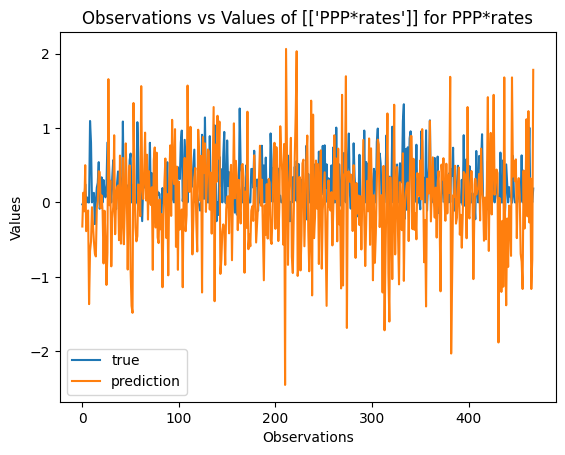

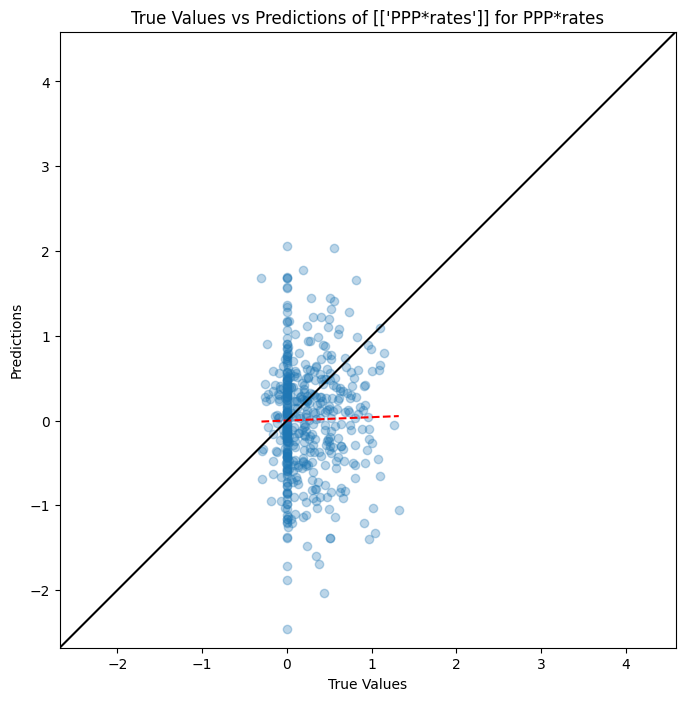

Correlation Coefficient: 0.018606862995898116
Calculating SHAP values...


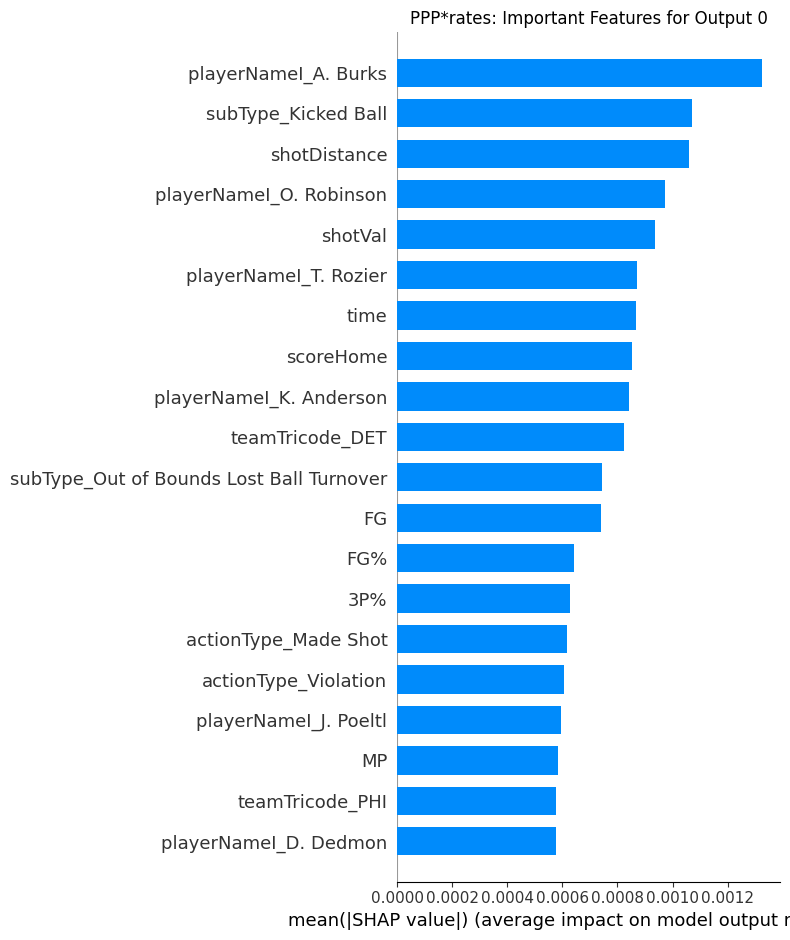


Splitting data and transforming features...


[I 2023-12-31 09:34:46,500] A new study created in RDB with name: reg ffn [['PPP*rates', 'scoreVal']] 0.0


Tuning Training a new reg ffn model to predict ['PPP*rates', 'scoreVal']...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 00002: reducing learning rate of group 0 to 2.4087e-02.
Epoch 00003: reducing learning rate of group 0 to 2.1192e-02.
Epoch 00004: reducing learning rate of group 0 to 1.8644e-02.
Epoch 00005: reducing learning rate of group 0 to 1.6403e-02.
Epoch 00006: reducing learning rate of group 0 to 1.4431e-02.
Epoch 00007: reducing learning rate of group 0 to 1.2696e-02.
Epoch 00008: reducing learning rate of group 0 to 1.1170e-02.
[I 2023-12-31 09:37:49,315] Trial 0 finished with value: inf and parameters: {'accumulate': 7, 'batch_size': 715, 'beta1': 0.9806817226261522, 'beta2': 0.7452612928490909, 'decay': 4.922992197331548e-05, 'epochs': 8, 'eps': 4.7913605386003275e-09, 'factor': 0.8797907918421691, 'ff_dropout_0': 0.33693918172574666, 'ff_dropout_1': 0.3554695479552902, 'ff_dropout_10': 0.6883275291937515, 'ff_dropout_2': 0.17077269854770372, 'ff_dropout_3': 0.9769283851918623, 'ff_dropout_4': 0.4534122404585843, 'ff_dropout_5': 0.5838673097867306, 'ff_dropout_6': 0.230088620670249

  0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-12-31 09:39:48,704] Trial 1 finished with value: 10367.281953692436 and parameters: {'accumulate': 2, 'batch_size': 136, 'beta1': 0.9274532088606259, 'beta2': 0.9963374173792559, 'decay': 0.023046257085880456, 'epochs': 3, 'eps': 8.819783922768965e-09, 'factor': 0.32651605719395993, 'ff_dropout_0': 0.5937690898749557, 'ff_dropout_1': 0.1936590562045749, 'ff_dropout_2': 0.011759887270451741, 'ff_dropout_3': 0.3185758452987908, 'ff_dropout_4': 0.22159325174355315, 'ff_dropout_5': 0.6733207544615885, 'ff_dropout_6': 0.2392122677547217, 'ff_dropout_7': 0.37952518434033455, 'ff_dropout_8': 0.3770890521590675, 'layer_0_size': 5714, 'layer_1_size': 4645, 'layer_2_size': 5072, 'layer_3_size': 4191, 'layer_4_size': 4220, 'layer_5_size': 2365, 'layer_6_size': 1590, 'layer_7_size': 3700, 'layer_8_size': 2268, 'lr': 4.930291967430558, 'n_layers': 9, 'patience': 0}. Best is trial 1 with value: 10367.281953692436.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-12-31 09:40:31,596] Trial 2 finished with value: 0.37538203597068787 and parameters: {'accumulate': 7, 'batch_size': 430, 'beta1': 0.5521606016962153, 'beta2': 0.7134927749680446, 'decay': 0.002257210486502466, 'epochs': 1, 'eps': 7.954658732689894e-09, 'factor': 0.839144842141139, 'ff_dropout_0': 0.4128114979979711, 'ff_dropout_1': 0.4416425238990269, 'ff_dropout_10': 0.9122581571197544, 'ff_dropout_11': 0.4519784805297892, 'ff_dropout_12': 0.5926999683811195, 'ff_dropout_2': 0.12061563139714004, 'ff_dropout_3': 0.841883616565962, 'ff_dropout_4': 0.5623648342356483, 'ff_dropout_5': 0.04099300938243311, 'ff_dropout_6': 0.2523350030288275, 'ff_dropout_7': 0.7389193943207666, 'ff_dropout_8': 0.6610237357666658, 'ff_dropout_9': 0.1644619044887986, 'layer_0_size': 5548, 'layer_10_size': 5558, 'layer_11_size': 2035, 'layer_12_size': 5548, 'layer_1_size': 5432, 'layer_2_size': 3393, 'layer_3_size': 3630, 'layer_4_size': 4157, 'layer_5_size': 1876, 'layer_6_size': 5471, 'layer_7_size'

  0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-12-31 09:42:29,930] Trial 3 finished with value: 0.45808928708235425 and parameters: {'accumulate': 8, 'batch_size': 50, 'beta1': 0.6275278199012927, 'beta2': 0.916741630006535, 'decay': 0.057510789727104585, 'epochs': 3, 'eps': 2.5161034867559846e-09, 'factor': 0.035521997477818035, 'ff_dropout_0': 0.30840389311948746, 'ff_dropout_1': 0.945918529958385, 'ff_dropout_2': 0.13543245609813037, 'ff_dropout_3': 0.5956772603124755, 'ff_dropout_4': 0.7614644811340718, 'ff_dropout_5': 0.2524346653303601, 'ff_dropout_6': 0.7186914934547611, 'layer_0_size': 6032, 'layer_1_size': 5003, 'layer_2_size': 3385, 'layer_3_size': 3952, 'layer_4_size': 3856, 'layer_5_size': 1678, 'layer_6_size': 1940, 'lr': 1.7376935890004936e-09, 'n_layers': 7, 'patience': 0}. Best is trial 2 with value: 0.37538203597068787.


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00002: reducing learning rate of group 0 to 3.5548e+00.
Epoch 00003: reducing learning rate of group 0 to 1.5471e+00.
Epoch 00004: reducing learning rate of group 0 to 6.7330e-01.
Epoch 00005: reducing learning rate of group 0 to 2.9302e-01.
Epoch 00006: reducing learning rate of group 0 to 1.2752e-01.
Epoch 00007: reducing learning rate of group 0 to 5.5499e-02.
Epoch 00008: reducing learning rate of group 0 to 2.4154e-02.
Epoch 00009: reducing learning rate of group 0 to 1.0512e-02.
Epoch 00010: reducing learning rate of group 0 to 4.5748e-03.
Epoch 00011: reducing learning rate of group 0 to 1.9910e-03.
[I 2023-12-31 10:00:31,461] Trial 4 finished with value: 0.36542072892189026 and parameters: {'accumulate': 6, 'batch_size': 566, 'beta1': 0.5141897529877067, 'beta2': 0.5970692271080862, 'decay': 0.016445887196770443, 'epochs': 11, 'eps': 7.20726279158933e-08, 'factor': 0.4352054432413155, 'ff_dropout_0': 0.6149791623691293, 'ff_dropout_1': 0.8966439524332958, 'ff_dropout_2': 

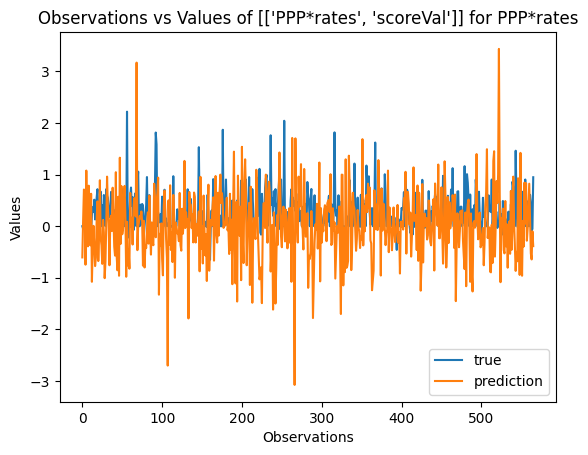

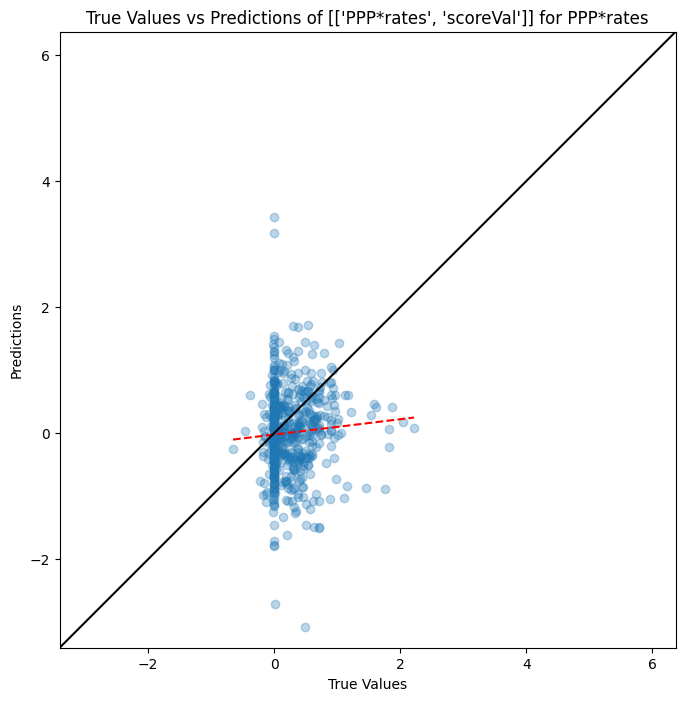

Correlation Coefficient: 0.002442876736254793


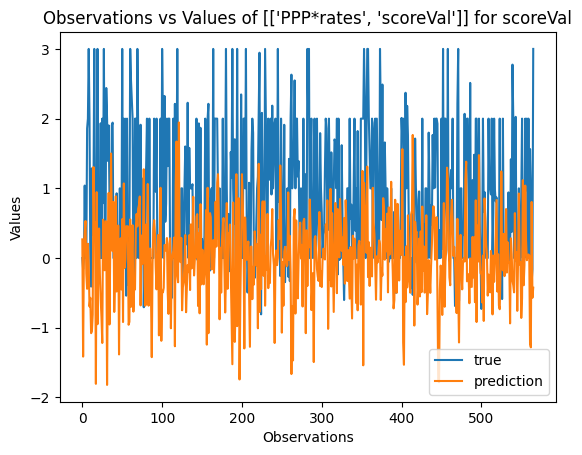

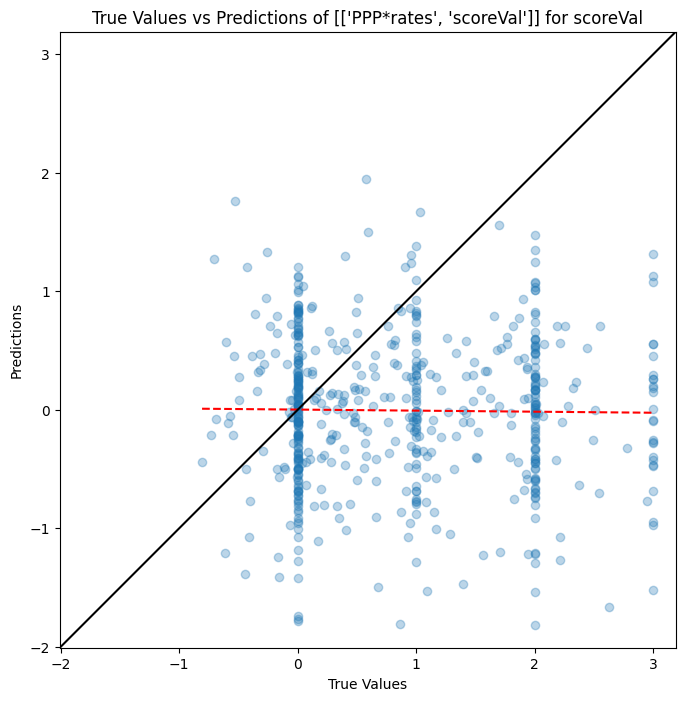

Correlation Coefficient: 0.002442876736254793
Calculating SHAP values...


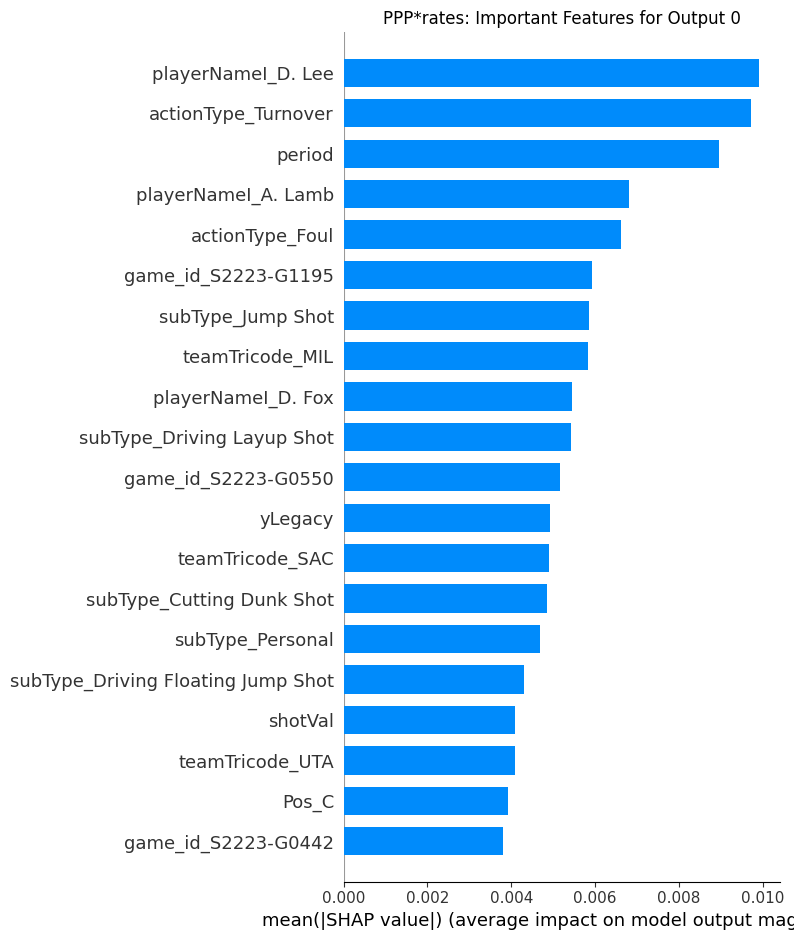

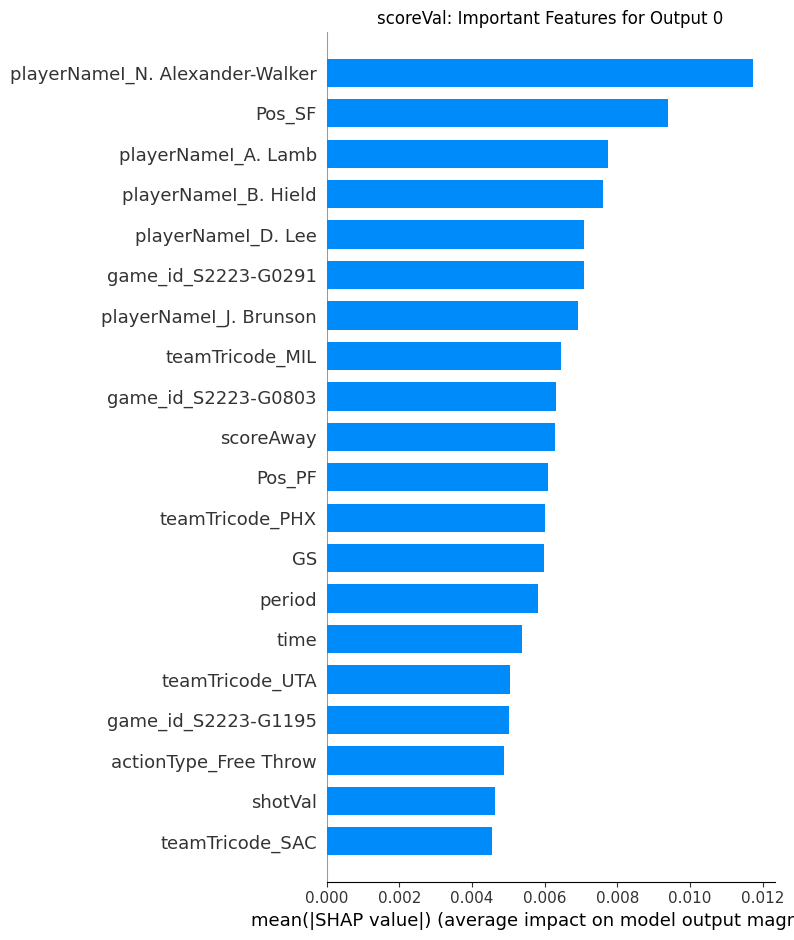


Splitting data and transforming features...
Resuming Training ['PPP*rates', 'scoreVal'] reg ffn model to predict ['PPP*rates', 'scoreVal']...


  0%|          | 0/11 [00:00<?, ?it/s]


Epoch 2
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5069290002187093
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.3287509083747864

Epoch 3
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4929714302221934
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.2926962673664093

Epoch 4
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.49499202768007916
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.28202569484710693

Epoch 5
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.49619853496551514
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.2814880609512329

Epoch 6
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.49914032220840454
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.2793857753276825

Epoch 7
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5040840208530426
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.2797584533691406
Epoch 00007: reducing learning rate of group 0 to 3.5548e+00.

Epoch 8
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4985661804676056
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.2807275354862213
Epoch 00008: reducing learning rate of group 0 to 1.5471e+00.

Epoch 9
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4963107208410899
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.2791471481323242

Epoch 10
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.5101542671521505
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.2805383801460266
Epoch 00010: reducing learning rate of group 0 to 6.7330e-01.

Epoch 11
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.49395161867141724
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.28298652172088623
Epoch 00011: reducing learning rate of group 0 to 2.9302e-01.

Epoch 12
--------
Training...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 0.4978581766287486
Validating...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.2825254201889038
Epoch 00012: reducing learning rate of group 0 to 1.2752e-01.
Testing the best model...


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.49966225028038025
epoch 9

Performance of reg ffn model:
	Root Mean Squared Error (RMSE): 1.1715118885040283
	Mean Absolute Error (MAE): 0.8782348036766052
	R^2 Score: -1.1658110618591309


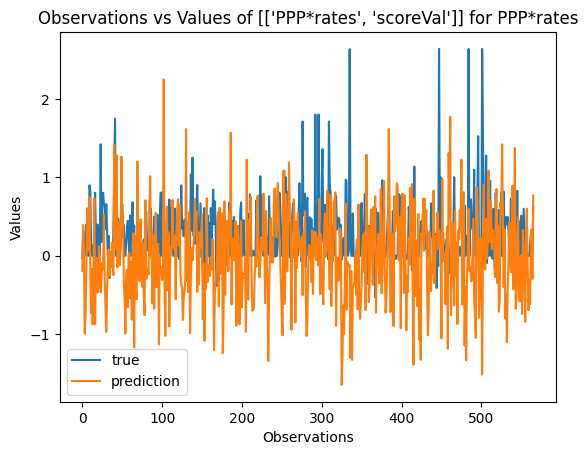

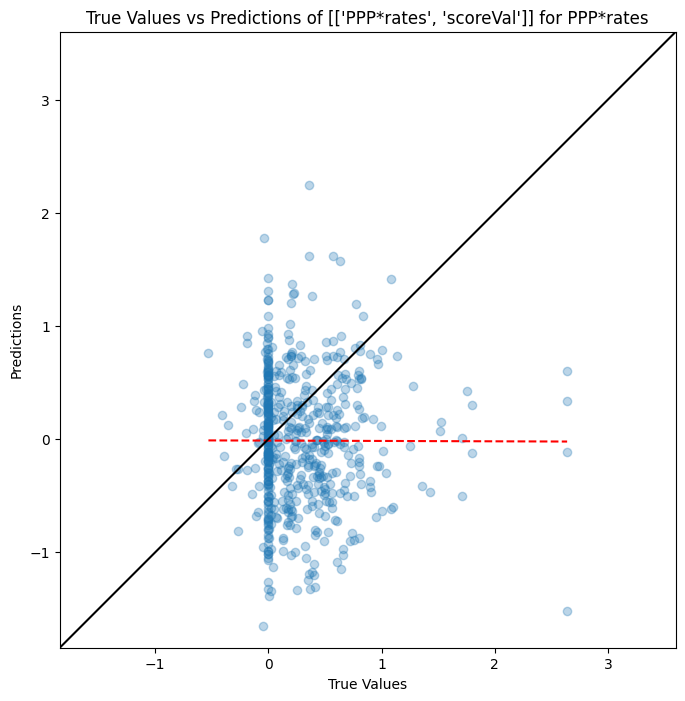

Correlation Coefficient: 0.0018532788631355998


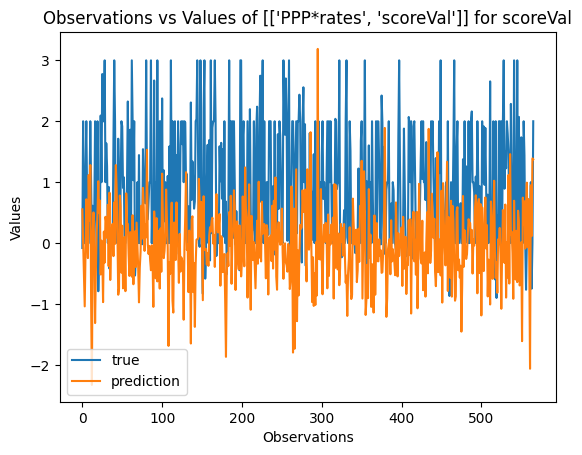

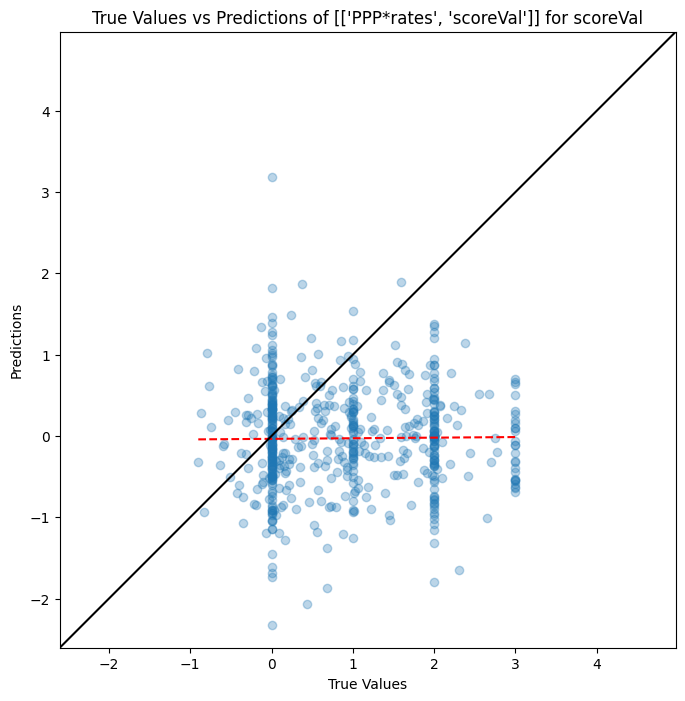

Correlation Coefficient: 0.0018532788631355998
Calculating SHAP values...


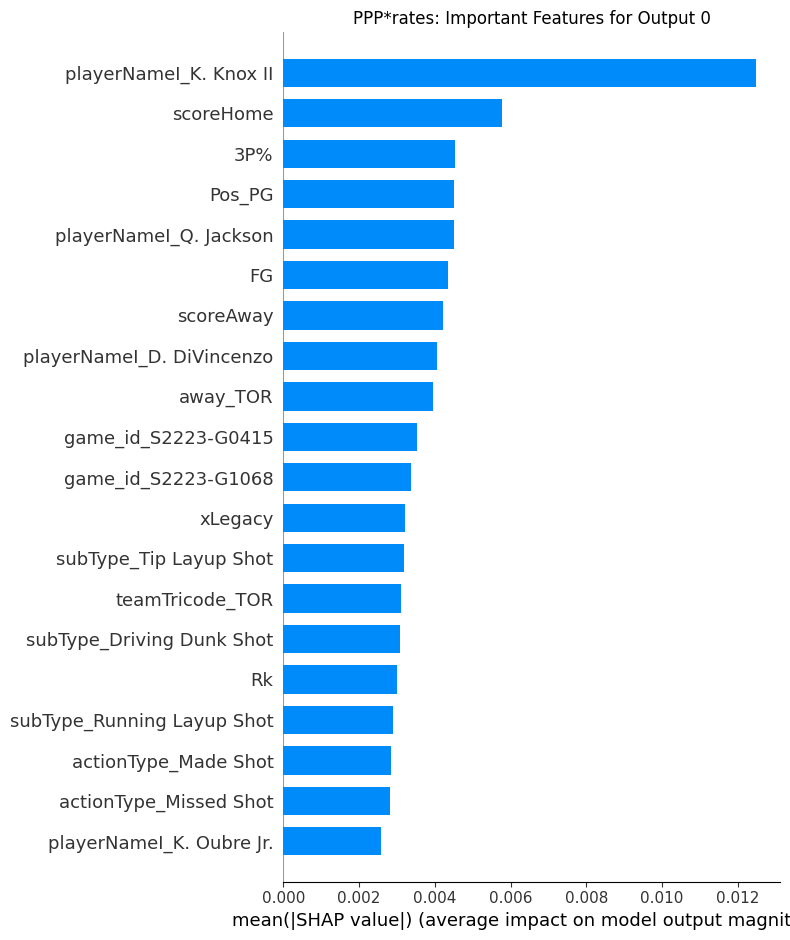

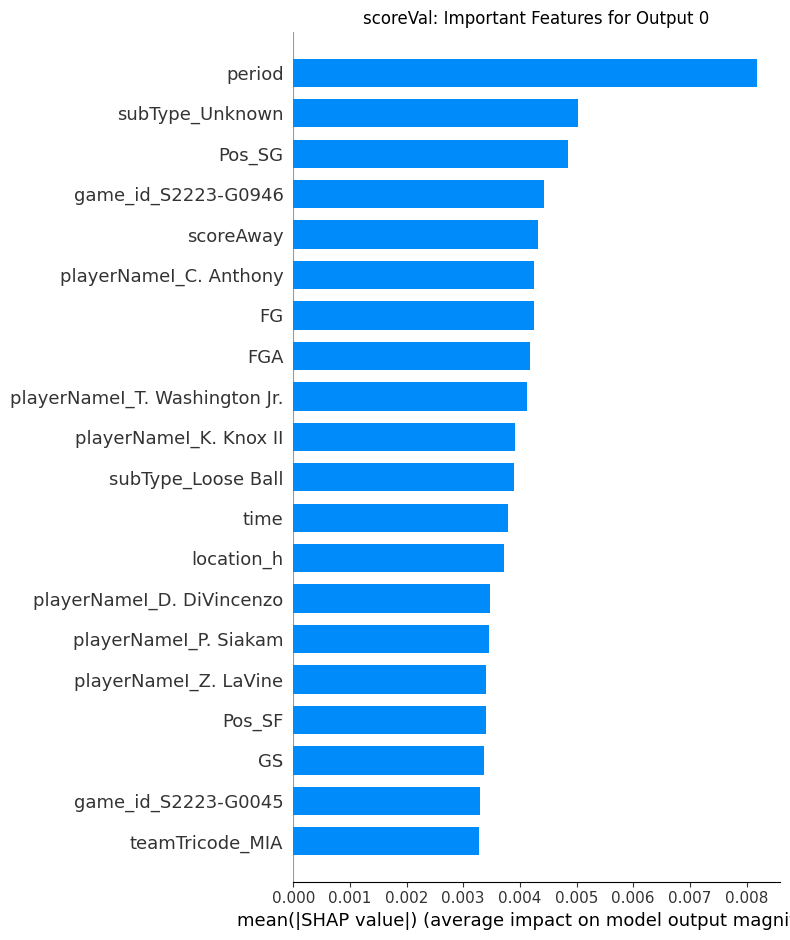

In [ ]:
models = {
    "tasks": [
        reg_opts,  # single-input/single-output
        # class_opts,  # single-input/multi-output
        multi_reg_opts,  # multi-input/single-output
        # multi_class_opts,  # multi-input/multi-output
    ],
    "archs": [
        ffn_opts,
        # rnn_opts
    ],
}

printedDashLink = False

for task in models["tasks"]:
    db = sqlite3.connect(task["db_path"])
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", db)

    for arch in models["archs"]:
        arch["client"] = Client(
            n_workers=task["n_workers"], silence_logs=logging.CRITICAL
        )
        if arch["client"] is not None and not task["colab"] and not printedDashLink:
            print(f'Dask dashboard is available at {arch["client"].dashboard_link}')
            printedDashLink = True

        trainer = Bronte(task | arch)
        with joblib.parallel_backend("dask"):
            for i, table in enumerate(tables["name"].tolist()):
                data = pd.DataFrame()
                if task["table_prefix"] in table:
                    data = pd.read_sql(f"SELECT * FROM {table}", db)
                    if task["verbose"]:
                        print("\nSplitting data and transforming features...")

                    df = data.copy()
                    if 0 < task["sample_size"] < 1:
                        df = df.sample(frac=task["sample_size"], random_state=42)
                    if 1 <= task["sample_size"] < len(df):
                        rg = np.random.default_rng(42)
                        n = rg.choice(len(df) - 1 - int(task["sample_size"]))
                        df = df.iloc[n : n + task["sample_size"], :].copy()

                    for col in df.columns:
                        if df[col].dtype == "object":
                            try:
                                df[col] = pd.to_numeric(df[col])
                            except ValueError:
                                pass

                    data = pd.get_dummies(df, dtype=np.int8, sparse=True)

                    if isinstance(task["targets"], str):
                        task["targets"] = [task["targets"]]
                    X = data.drop(columns=task["targets"])
                    y = data[task["targets"]]
                    if trainer.fit(X, y) != 0 or i >= task["samples"] - 1:
                        break

        if arch["client"] is not None:
            arch["client"].close()
            arch["client"] = None
    db.close()

# Inference


In [ ]:
# Load the models
models = []

for root, dirs, files in os.walk("models"):
    if "checkpoints" in dirs:
        dirs.remove("checkpoints")
    for file in files:
        if file.endswith(".pt"):
            trainer = Bronte(path=os.path.join(root, file))
            models.append(trainer.model)

print("Loaded models:")
for model in models:
    print(f"\t{model.typeof}: {model.name} ({model.fits} fit(s))")

# Extract and transform new data
# ...

# Use the trained model(s) to predict
# predictions = [model.predict(X) for model in models]

Loaded models:
	reg ffn: [['PPP*rates']] (1 fit(s))
	reg ffn: [['PPP*rates']] (2 fit(s))
	reg ffn: [['PPP*rates', 'scoreVal']] (1 fit(s))
	reg ffn: [['PPP*rates', 'scoreVal']] (2 fit(s))
